In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

from utils import *
from settings import station_locale, data_root, output_folder, report_folder

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
data_root = '../data/'
air_quality_list = ['airQuality_201701-201801.csv', 'airQuality_201802-201803.csv', 'aiqQuality_201804.csv']
grid_weather_list = ['gridWeather_201701-201803.csv', 'gridWeather_201804.csv', 'gridWeather_20180501-20180502.csv']
ob_weather_list = ['observedWeather_201701-201801.csv', 'observedWeather_201802-201803.csv',
                   'observedWeather_201804.csv', 'observedWeather_20180501-20180502.cs']

In [4]:
! ls  -l ../data

total 1265664
-rw-r--r--@ 1 leonling  staff      11161 Sep 19 15:43 Beijing_AirQuality_Stations_en.xlsx
-rw-r--r--@ 1 leonling  staff      17874 Sep 19 15:47 Beijing_grid_weather_station.csv
-rw-r--r--@ 1 leonling  staff    1603077 Sep 22 21:27 aiqQuality_201804.csv
-rw-r--r--@ 1 leonling  staff   18523061 Sep 19 15:50 airQuality_201701-201801.csv
-rw-r--r--@ 1 leonling  staff    2919660 Sep 22 21:22 airQuality_201802-201803.csv
-rw-r--r--@ 1 leonling  staff  554911410 Sep 19 15:44 gridWeather_201701-201803.csv
-rw-r--r--@ 1 leonling  staff   40972190 Sep 22 21:48 gridWeather_201804.csv
-rw-r--r--@ 1 leonling  staff    2770682 Sep 22 21:49 gridWeather_20180501-20180502.csv
-rw-r--r--@ 1 leonling  staff   16134464 Sep 19 15:33 observedWeather_201701-201801.csv
-rw-r--r--@ 1 leonling  staff    1732433 Sep 19 19:04 observedWeather_201802-201803.csv
-rw-r--r--@ 1 leonling  staff     978466 Sep 22 21:31 observedWeather_201804.csv
-rw-r--r--@ 1 leonling  staff      66049 Sep 22 21:35 observe

## Load Data 

### air quality data

In [18]:
df_aq = load_data('airQuality_201701-201801.csv')
df_aq2 = load_data('airQuality_201802-201803.csv')
df_aq3 = load_data('aiqQuality_201804.csv')
df_aq = df_aq.append(df_aq2)
new_names = {'station_id': 'stationId',
             'time': 'utc_time',
             'PM25_Concentration': 'PM2.5',
             'PM10_Concentration': 'PM10',
             'NO2_Concentration': 'NO2',
             'CO_Concentration': 'CO',
             'O3_Concentration': 'O3',
             'SO2_Concentration': 'SO2'
            }
df_aq3.set_index('id', inplace=True)
df_aq3.rename(columns=new_names, inplace=True)
df_aq = df_aq.append(df_aq3, sort=False)
df_aq = df_aq.reset_index().drop(['index'], axis=1)

In [19]:
df_aq.isna().any()
temp = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
for i in temp:
    print(f'{i}: {len(df_aq[i])-df_aq[[i]].count()}')
print(len(df_aq))

PM2.5: PM2.5    24694
dtype: int64
PM10: PM10    101060
dtype: int64
NO2: NO2    22768
dtype: int64
CO: CO    47189
dtype: int64
O3: O3    24924
dtype: int64
SO2: SO2    22690
dtype: int64
383740


In [25]:
df_aq.head()

,stationId,utc_time,PM2.5,PM10,NO2,CO,O3,SO2
0,aotizhongxin_aq,2017-01-01 14:00:00,453.0,467.0,156.0,7.2,3.0,9.0
1,aotizhongxin_aq,2017-01-01 15:00:00,417.0,443.0,143.0,6.8,2.0,8.0
2,aotizhongxin_aq,2017-01-01 16:00:00,395.0,467.0,141.0,6.9,3.0,8.0
3,aotizhongxin_aq,2017-01-01 17:00:00,420.0,484.0,139.0,7.4,3.0,9.0
4,aotizhongxin_aq,2017-01-01 18:00:00,453.0,520.0,157.0,7.6,4.0,9.0


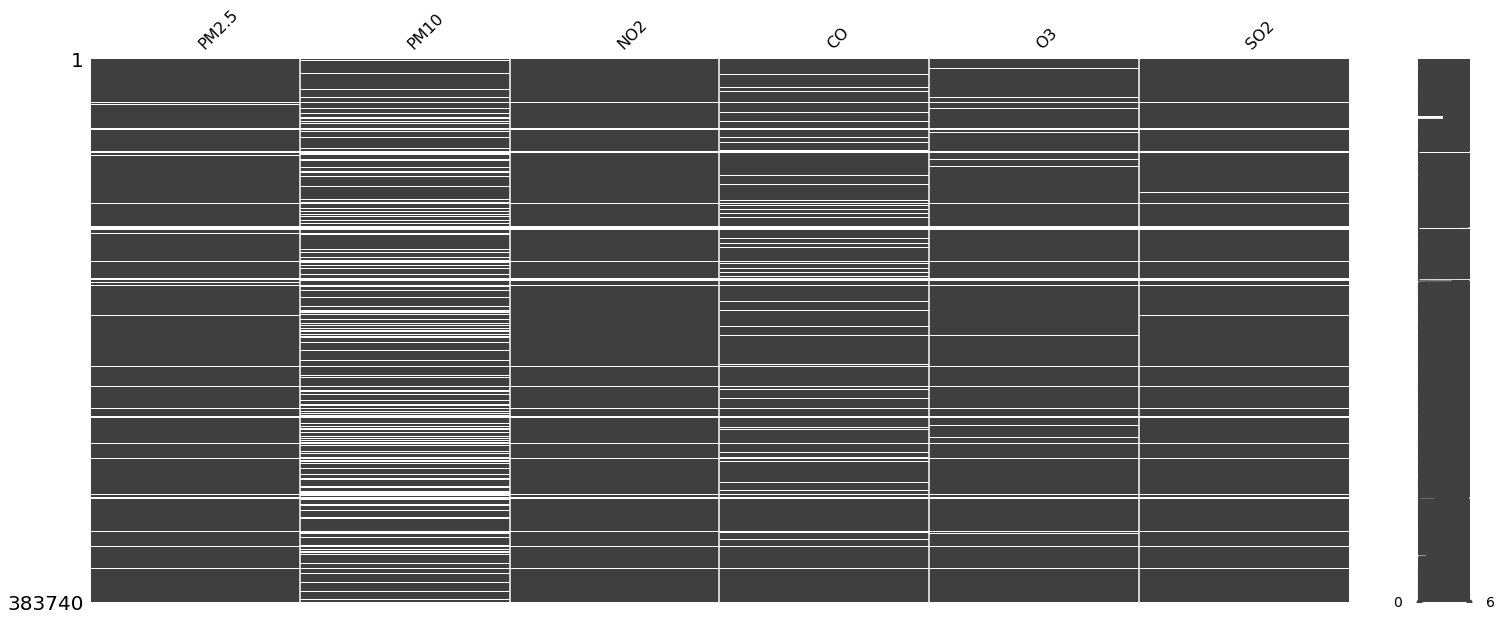

In [38]:
import missingno as msno
%matplotlib inline
msno.matrix(df_aq[temp])

In [7]:
df_aq.iloc[1369:1371]  # need to drop duplicated records

,stationId,utc_time,PM2.5,PM10,NO2,CO,O3,SO2
1369,aotizhongxin_aq,2017-03-02 16:00:00,76.0,119.0,95.0,1.5,29.0,31.0
1370,aotizhongxin_aq,2017-03-02 16:00:00,76.0,119.0,95.0,1.5,29.0,31.0


In [8]:
df_aq['longitude'] = df_aq['stationId'].map(lambda x: station_locale[x][0][0])
df_aq['latitude'] = df_aq['stationId'].map(lambda x: station_locale[x][0][1])
df_aq['area'] = df_aq['stationId'].map(lambda x: station_locale[x][1])
df_aq['local_time'] = df_aq['utc_time'].map(lambda x: utc2local(x))
df_aq['date'] = df_aq['local_time'].map(lambda x: x.split()[0])
df_aq['time'] = df_aq['local_time'].map(lambda x: x.split()[1])
# df_aq['solar_term'] = df_aq['date'].map(lambda x: get_solar_term(x))
df_aq['solar_term'] = df_aq['date'].map(lambda x: get_solar_term(x, periodicity=False))
df_aq['time_label'] = df_aq['time'].map(lambda x: get_time_label(x))

In [9]:
# nominal columns to numerical columns
df_aq = df_aq.drop(['area'], axis=1).join(pd.get_dummies(df_aq['area']))
df_aq['datetime_label'] = LabelEncoder().fit_transform(df_aq['local_time'])

In [10]:
temp_df = df_aq[['stationId', 'datetime_label', 'solar_term', 'time_label',
                 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2',
                 'longitude', 'latitude', 'Urban', 'SubUrban', 'NearTraffic', 'Others']]

In [11]:
measures = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
neibours = 7
weight = 'distance' # 'uniform', 'distance'
# maybe different measures can apply diff params

tmp_measures = {}
for tag in measures:
    temp_test_x = temp_df[temp_df[tag].isna().values == True][['solar_term', 'time_label', 'longitude', 'latitude', 
                                                               'Urban', 'SubUrban', 'NearTraffic', 'Others']]
    temp_train_x = temp_df.dropna(subset=[tag])[['solar_term', 'time_label', 'longitude', 'latitude', 
                                                     'Urban', 'SubUrban', 'NearTraffic', 'Others']]
    temp_train_y = temp_df.dropna(subset=[tag])[[tag]]
    
    knn = KNeighborsRegressor(n_neighbors=neibours, weights=weight)
    y = knn.fit(temp_train_x, temp_train_y).predict(temp_test_x)

    tmp_measures[tag] = temp_df[temp_df[tag].isna().values == True][['datetime_label', 'longitude', 'latitude']]
    tmp_measures[tag][tag] = y

In [12]:
list(tmp_measures.keys())

['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']

In [10]:
# temp_test_x = temp_df[temp_df['O3'].isna().values == True][['solar_term', 'time_label', 'longitude', 'latitude', 
#                                                                'Urban', 'SubUrban', 'NearTraffic', 'Others']]
# temp_train_x = temp_df.dropna(subset=['O3'])[['solar_term', 'time_label', 'longitude', 'latitude', 
#                                                  'Urban', 'SubUrban', 'NearTraffic', 'Others']]
# temp_train_y = temp_df.dropna(subset=['O3'])[['O3']]


# neibours = 7
# weight = 'distance' # 'uniform', 'distance'

# knn = KNeighborsRegressor(n_neighbors=neibours, weights=weight)
# y = knn.fit(temp_train_x, temp_train_y).predict(temp_test_x)

# temp_o3 = temp_df[temp_df['O3'].isna().values == True][['datetime_label', 'longitude', 'latitude']]
# temp_o3['O3'] = y

#### Plotting

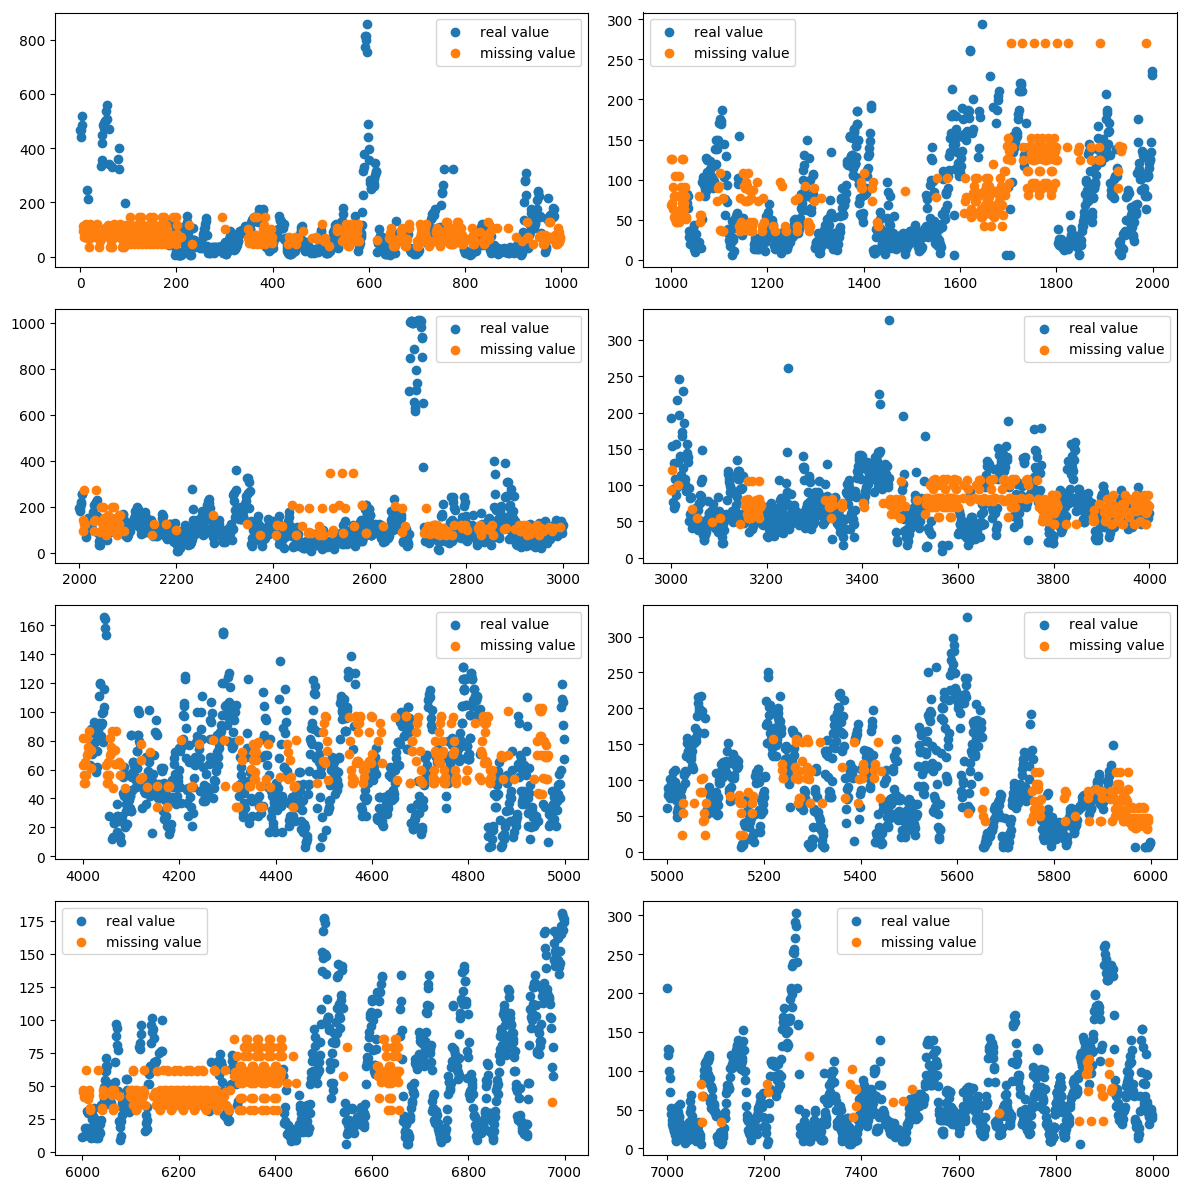

In [19]:

plt.figure(figsize=(12,12), dpi=100)

for i in range(8):
    plt.subplot(4,2,i+1)
    qry = f'longitude==116.397 and latitude==39.982 and datetime_label<{1000*(i+1)} and datetime_label>={1000*(i)}'
    plt.scatter(temp_df.query(qry)['datetime_label'], temp_df.query(qry)[['PM10']], label='real value')
    plt.scatter(temp_pm10.query(qry)['datetime_label'], temp_pm10.query(qry)[['PM10']], label='missing value')
#     plt.title(f'KNN O3 Missing value')
    plt.axis('tight')
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'KNN_PM10_Missing_value_NO_PERIOD_data.jpg'))
plt.show()

In [13]:
# temp_pm25 = temp_pm25.reset_index()
# temp_pm10 = temp_pm10.reset_index()
# temp_o3 = temp_o3.reset_index()

# print('pm25')
# for i in temp_pm25['index']:
#     qry = f'index=={i}'
#     df_aq.at[i, 'PM2.5'] = temp_pm25.query(qry)['PM2.5']

# print('pm10')
# for i in temp_pm10['index']:
#     qry = f'index=={i}'
#     df_aq.at[i, 'PM10'] = temp_pm10.query(qry)['PM10']

# print('o3')   
# for i in temp_o3['index']:
#     qry = f'index=={i}'
#     df_aq.at[i, 'O3'] = temp_o3.query(qry)['O3']
    
for key, value in tmp_measures.items():
    print(key)
    tmp = tmp_measures[key].reset_index()
    
    for i in tmp['index']:
        qry = f'index=={i}'
        df_aq.at[i, key] = tmp.query(qry)[key]

PM2.5
PM10
NO2
CO
O3
SO2


In [14]:
df_aq.isna().any()

stationId         False
utc_time          False
PM2.5             False
PM10              False
NO2               False
CO                False
O3                False
SO2               False
longitude         False
latitude          False
local_time        False
date              False
time              False
solar_term        False
time_label        False
NearTraffic       False
Others            False
SubUrban          False
Urban             False
datetime_label    False
dtype: bool

In [15]:
df_aq.to_csv(os.path.join(output_folder, 'air_quality_miss_filled.zip'), compression='zip')

In [16]:
del df_aq
del df_aq2
del df_aq3
del tmp_measures

In [17]:
air_df = pd.read_csv(os.path.join(output_folder, 'air_quality_miss_filled.zip'))

air_df.drop(['Unnamed: 0', 'utc_time'], axis=1, inplace=True)

atzx = air_df.query('stationId=="nongzhanguan_aq"')

# atzx.query('datetime_label==2587')
# air_df.iloc[1369:1371]

a = air_df.drop_duplicates(subset=['stationId', 'datetime_label'], keep='first')
b = air_df.drop_duplicates(subset=['stationId', 'datetime_label'], keep=False)
print(len(air_df)-len(a))

air_df = air_df.drop_duplicates(subset=['stationId', 'datetime_label'], keep='first')
air_df.rename(columns={'stationId': 'station_id'}, inplace=True)

air_df.to_csv(os.path.join(output_folder, 'air_quality_no_duplicates.zip'), compression='zip')

# aq_nodup = pd.read_csv(os.path.join(output_folder, 'air_quality_no_duplicates.zip'))

# len(aq_nodup) # 383740 - 377265 = 6475

6475


### grid weather data

In [99]:
df_gw2 = load_data('gridWeather_201804.csv')
df_gw2.head()

,id,station_id,time,weather,temperature,pressure,humidity,wind_direction,wind_speed
0,2027019,beijing_grid_000,2018-04-01 00:00:00,CLEAR_DAY,15.0,974.1536,21.0,346.93,4.18
1,2027020,beijing_grid_001,2018-04-01 00:00:00,CLEAR_DAY,15.0,960.6752,20.0,329.47,4.50
2,2027021,beijing_grid_002,2018-04-01 00:00:00,CLEAR_DAY,9.0,947.1968,19.0,315.38,5.16
3,2027022,beijing_grid_003,2018-04-01 00:00:00,CLEAR_DAY,9.0,931.8720,19.0,307.81,5.74
4,2027023,beijing_grid_004,2018-04-01 00:00:00,CLEAR_DAY,9.0,914.7008,20.0,304.23,6.08


In [100]:
temp_df = df_gw2.query('station_id == "beijing_grid_224"')
temp_df['date'] = temp_df['time'].map(lambda x: x.split()[0])
temp_df['clock'] = temp_df['time'].map(lambda x: x.split()[1])
temp = temp_df.groupby('clock').agg({'temperature': 'mean',
                              'pressure': 'mean',
                              'humidity': 'mean'
                             }).copy()

/Users/leonling/workspace/pyenv/scientific/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/leonling/workspace/pyenv/scientific/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


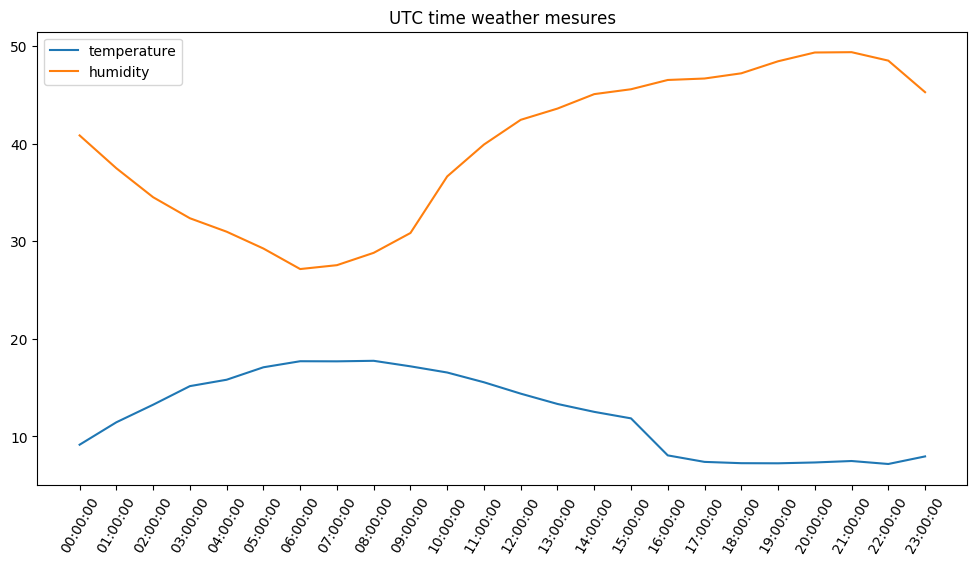

In [54]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(temp[['temperature']], label='temperature')
# plt.plot(temp[['pressure']], label='pressure')
plt.plot(temp[['humidity']], label='humidity')
plt.xticks(rotation=60)
plt.title(f'UTC time weather mesures')
# plt.axis('tight')
plt.legend()
plt.savefig(os.path.join(output_folder, 'UTC_weather_mesures_1804.jpg'))
plt.show()


In [23]:
temp_df['time'] = temp_df['time'].map(lambda x: utc2local(x))
temp_df['date'] = temp_df['time'].map(lambda x: x.split()[0])
temp_df['clock'] = temp_df['time'].map(lambda x: x.split()[1])
temp = temp_df.groupby('clock').agg({'temperature': 'mean',
                              'pressure': 'mean',
                              'humidity': 'mean'
                             }).copy()

/Users/leonling/workspace/pyenv/scientific/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/leonling/workspace/pyenv/scientific/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/leonling/workspace/pyenv/scientific/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

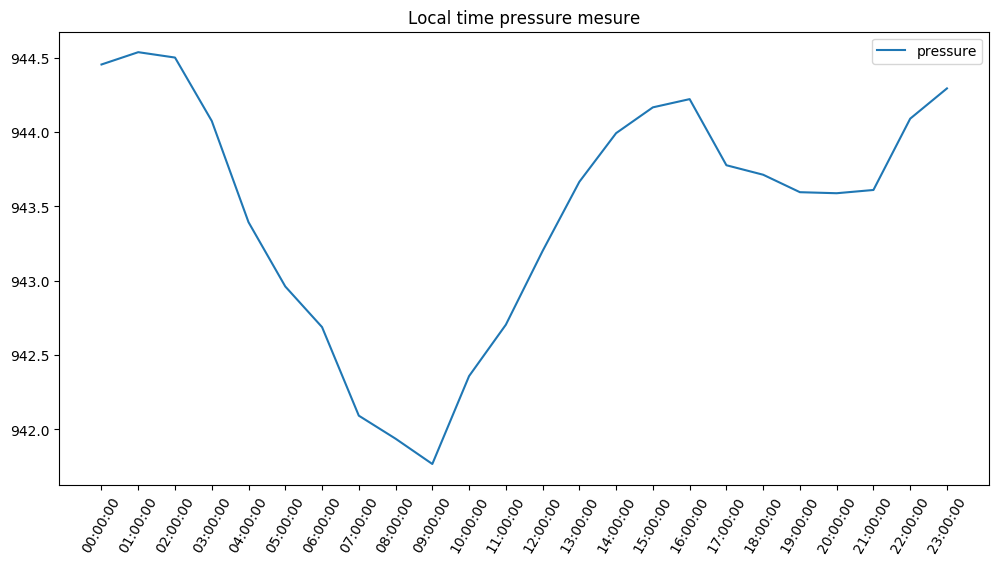

In [101]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(temp[['pressure']], label='pressure')
plt.xticks(rotation=60)
plt.title(f'Local time pressure mesure')
# plt.axis('tight')
plt.legend()
plt.savefig(os.path.join(output_folder, 'Local_weather_mesures_pressure_1804.jpg'))
plt.show()

In [103]:
del temp_df

In [5]:
df_gw = load_data('gridWeather_201701-201803.csv')
print(len(df_gw))
df_gw.head()

7034706


,stationName,longitude,latitude,utc_time,temperature,pressure,humidity,wind_direction,wind_speed/kph
0,beijing_grid_000,115.0,39.0,2017-01-01 00:00:00,-5.47,984.73,76.60,53.71,3.53
1,beijing_grid_001,115.0,39.1,2017-01-01 00:00:00,-5.53,979.33,75.40,43.59,3.11
2,beijing_grid_002,115.0,39.2,2017-01-01 00:00:00,-5.70,963.14,71.80,0.97,2.75
3,beijing_grid_003,115.0,39.3,2017-01-01 00:00:00,-5.88,946.94,68.20,327.65,3.84
4,beijing_grid_004,115.0,39.4,2017-01-01 00:00:00,-5.34,928.80,58.81,317.85,6.14


In [6]:
df_gw['local_time'] = df_gw['utc_time'].map(lambda x: utc2local(x))
df_gw = df_gw.rename(columns={'stationName':'station_id'})  #  'wind_speed/kph':'wind_speed'
df_gw['wind_speed'] = df_gw['wind_speed/kph'] / 3.6

df_gw = df_gw[['station_id','longitude', 'latitude','local_time',
              'temperature','pressure','humidity','wind_direction','wind_speed']]

In [7]:
stations = df_gw['station_id'].unique()
gr_station_positions = {}
for srt in stations:
    qry = f'station_id=="{srt}"'
    position = df_gw.query(qry)[['longitude', 'latitude']].iloc[0]
    gr_station_positions[srt] = (position['longitude'], position['latitude'])

In [8]:
# df_gw

In [9]:
df_gw2 = load_data('gridWeather_201804.csv')
print(len(df_gw2))
df_gw2.head()

463476


,id,station_id,time,weather,temperature,pressure,humidity,wind_direction,wind_speed
0,2027019,beijing_grid_000,2018-04-01 00:00:00,CLEAR_DAY,15.0,974.1536,21.0,346.93,4.18
1,2027020,beijing_grid_001,2018-04-01 00:00:00,CLEAR_DAY,15.0,960.6752,20.0,329.47,4.50
2,2027021,beijing_grid_002,2018-04-01 00:00:00,CLEAR_DAY,9.0,947.1968,19.0,315.38,5.16
3,2027022,beijing_grid_003,2018-04-01 00:00:00,CLEAR_DAY,9.0,931.8720,19.0,307.81,5.74
4,2027023,beijing_grid_004,2018-04-01 00:00:00,CLEAR_DAY,9.0,914.7008,20.0,304.23,6.08


In [10]:
df_gw2['local_time'] = df_gw2['time'].map(lambda x: utc2local(x))
df_gw2.rename(columns={'stationName':'station_id'})
df_gw2['longitude'] = df_gw2['station_id'].map(lambda x: gr_station_positions[x][0])
df_gw2['latitude'] = df_gw2['station_id'].map(lambda x: gr_station_positions[x][1])

temp = df_gw2.copy()
df_gw2 = df_gw2[['station_id','longitude', 'latitude','local_time',
              'temperature','pressure','humidity','wind_direction','wind_speed']]

In [11]:
df_gw = df_gw.append(df_gw2)

In [12]:
df_gw.isna().any()

station_id        False
longitude         False
latitude          False
local_time        False
temperature       False
pressure          False
humidity          False
wind_direction    False
wind_speed        False
dtype: bool

In [13]:
df_gw['date'] = df_gw['local_time'].map(lambda x: x.split()[0])
df_gw['time'] = df_gw['local_time'].map(lambda x: x.split()[1])
df_gw['solar_term'] = df_gw['date'].map(lambda x: get_solar_term(x, periodicity=False))
df_gw['time_label'] = df_gw['time'].map(lambda x: get_time_label(x))
le = LabelEncoder()
df_gw['datetime_label'] = le.fit_transform(df_gw['local_time'])

In [14]:
temp = temp[['station_id','longitude', 'latitude','local_time',
             'temperature','pressure','humidity','wind_direction','wind_speed','weather']]
temp['date'] = temp['local_time'].map(lambda x: x.split()[0])
temp['time'] = temp['local_time'].map(lambda x: x.split()[1])
temp['solar_term'] = temp['date'].map(lambda x: get_solar_term(x, periodicity=False))
temp['time_label'] = temp['time'].map(lambda x: get_time_label(x))
temp['datetime_label'] = le.transform(temp['local_time'])

In [15]:
temp = temp.drop_duplicates(subset=['station_id', 'datetime_label'], keep='first')
temp.to_csv(os.path.join(output_folder, 'grid_weather_with_weather.zip'), compression='zip')

In [16]:
# a = df_gw.drop_duplicates(subset=['station_id', 'datetime_label'], keep='first')
# # b = df_gw.drop_duplicates(subset=['stationId', 'datetime_label'], keep=False)
# print(len(df_gw)-len(a))
df_gw = df_gw.drop_duplicates(subset=['station_id', 'datetime_label'], keep='first')
df_gw = df_gw.reset_index().drop(['index'], axis=1)

In [17]:
df_gw.to_csv(os.path.join(output_folder, 'grid_weather_processed.zip'), compression='zip')

In [142]:
df_gw4 = load_data('gridWeather_20180501-20180502.csv')
print(len(df_gw4))
df_gw4.head()

31245


,id,station_id,time,weather,temperature,pressure,humidity,wind_direction,wind_speed
0,3116510,beijing_grid_000,2018-05-01 00:00:00,CLOUDY,20.0,975.6105,52.0,76.64,4.38
1,3116511,beijing_grid_001,2018-05-01 00:00:00,CLOUDY,20.0,962.0873,49.0,58.35,3.82
2,3116512,beijing_grid_002,2018-05-01 00:00:00,CLOUDY,13.0,948.5641,46.0,36.82,3.75
3,3116513,beijing_grid_003,2018-05-01 00:00:00,CLOUDY,13.0,933.2105,43.0,9.52,4.65
4,3116514,beijing_grid_004,2018-05-01 00:00:00,CLOUDY,13.0,916.0265,42.0,350.17,6.88


In [144]:
df_gw4['local_time'] = df_gw4['time'].map(lambda x: utc2local(x))
df_gw4.rename(columns={'stationName':'station_id', 'wind_speed/kph':'wind_speed'})
df_gw4['longitude'] = df_gw4['station_id'].map(lambda x: gr_station_positions[x][0])
df_gw4['latitude'] = df_gw4['station_id'].map(lambda x: gr_station_positions[x][1])

df_gw4 = df_gw4[['station_id','longitude', 'latitude','local_time',
              'temperature','pressure','humidity','wind_direction','wind_speed','weather']]

df_gw4['date'] = df_gw4['local_time'].map(lambda x: x.split()[0])
df_gw4['time'] = df_gw4['local_time'].map(lambda x: x.split()[1])
df_gw4['solar_term'] = df_gw4['date'].map(lambda x: get_solar_term(x, periodicity=False))
df_gw4['time_label'] = df_gw4['time'].map(lambda x: get_time_label(x))
le = LabelEncoder()
df_gw4['datetime_label'] = le.fit_transform(df_gw4['local_time'])

In [146]:
df_gw4.to_csv(os.path.join(output_folder, 'grid_weather_test.zip'), compression='zip')

In [147]:
del df_gw
del df_gw2
del df_gw4
del gr_station_positions

### observed weather data

In [55]:
df_ow = load_data('observedWeather_201701-201801.csv')
print(len(df_ow))
df_ow.head()

158047


,station_id,longitude,latitude,utc_time,temperature,pressure,humidity,wind_direction,wind_speed,weather
0,shunyi_meo,116.615278,40.126667,2017-01-30 16:00:00,-1.7,1028.7,15,215.0,1.6,Sunny/clear
1,shunyi_meo,116.615278,40.126667,2017-01-30 17:00:00,-3.5,1028.4,24,16.0,1.0,Haze
2,shunyi_meo,116.615278,40.126667,2017-01-30 18:00:00,-3.7,1028.1,27,32.0,1.1,Haze
3,shunyi_meo,116.615278,40.126667,2017-01-30 19:00:00,-3.9,1027.6,27,21.0,0.9,Haze
4,shunyi_meo,116.615278,40.126667,2017-01-30 20:00:00,-4.1,1026.7,26,17.0,1.1,Haze


In [56]:
stations = df_ow['station_id'].unique()
ob_station_positions = {}
for srt in stations:
    qry = f'station_id=="{srt}"'
    position = df_ow.query(qry)[['longitude', 'latitude']].iloc[0]
    ob_station_positions[srt] = (position['longitude'], position['latitude'])

In [57]:
df_ow['local_time'] = df_ow['utc_time'].map(lambda x: utc2local(x))
# df_ow['date'] = df_ow['local_time'].map(lambda x: x.split()[0])
# df_ow['time'] = df_ow['local_time'].map(lambda x: x.split()[1])
# df_ow['solar_term'] = df_ow['date'].map(lambda x: get_solar_term(x, periodicity=False))
# df_ow['time_label'] = df_ow['time'].map(lambda x: get_time_label(x))
# df_ow['datetime_label'] = LabelEncoder().fit_transform(df_ow['local_time'])
# df_ow = df_ow.drop(['utc_time'], axis=1)
df_ow = df_ow[['station_id','longitude', 'latitude','local_time',
              'temperature','pressure','humidity','wind_direction','wind_speed','weather']]

In [58]:
df_ow[df_ow.isna().values==True]

,station_id,longitude,latitude,local_time,temperature,pressure,humidity,wind_direction,wind_speed,weather
8155,shunyi_meo,116.615278,40.126667,2018-01-05 19:00:00,-3.9,1023.0,35,NaN,NaN,Sunny/clear
8155,shunyi_meo,116.615278,40.126667,2018-01-05 19:00:00,-3.9,1023.0,35,NaN,NaN,Sunny/clear
8156,shunyi_meo,116.615278,40.126667,2018-01-05 20:00:00,-5.2,1023.6,47,NaN,NaN,Sunny/clear
8156,shunyi_meo,116.615278,40.126667,2018-01-05 20:00:00,-5.2,1023.6,47,NaN,NaN,Sunny/clear
8157,shunyi_meo,116.615278,40.126667,2018-01-05 21:00:00,-4.1,1023.9,35,NaN,NaN,Sunny/clear
8157,shunyi_meo,116.615278,40.126667,2018-01-05 21:00:00,-4.1,1023.9,35,NaN,NaN,Sunny/clear
8158,shunyi_meo,116.615278,40.126667,2018-01-05 22:00:00,-4.4,1024.1,35,NaN,NaN,Sunny/clear
8158,shunyi_meo,116.615278,40.126667,2018-01-05 22:00:00,-4.4,1024.1,35,NaN,NaN,Sunny/clear
8159,shunyi_meo,116.615278,40.126667,2018-01-05 23:00:00,-4.7,1024.7,35,NaN,NaN,Sunny/clear
8159,shunyi_meo,116.615278,40.126667,2018-01-05 23:00:00,-4.7,1024.7,35,NaN,NaN,Sunny/clear


In [59]:
df_ow2 = load_data('observedWeather_201802-201803.csv')
print(len(df_ow2))
df_ow2.head()

26676


,station_id,utc_time,weather,temperature,pressure,humidity,wind_speed,wind_direction
0,beijing_meo,2018-01-31 16:00:00,Sunny/clear,-4.8,1023.9,39,0.9,59
1,beijing_meo,2018-01-31 17:00:00,Sunny/clear,-6.1,1023.4,42,0.0,999017
2,beijing_meo,2018-01-31 18:00:00,Sunny/clear,-7.0,1023.1,45,0.5,178
3,beijing_meo,2018-01-31 19:00:00,Haze,-7.7,1022.8,47,0.0,999017
4,beijing_meo,2018-01-31 20:00:00,Sunny/clear,-6.3,1022.4,44,2.0,71


In [61]:
df_ow2['longitude'] = df_ow2['station_id'].map(lambda x: ob_station_positions[x][0])
df_ow2['latitude'] = df_ow2['station_id'].map(lambda x: ob_station_positions[x][1])
df_ow2['local_time'] = df_ow2['utc_time'].map(lambda x: utc2local(x))
df_ow2 = df_ow2[['station_id','longitude', 'latitude','local_time',
              'temperature','pressure','humidity','wind_direction','wind_speed','weather']]

In [62]:
df_ow2[df_ow2.isna().values==True]

,station_id,longitude,latitude,local_time,temperature,pressure,humidity,wind_direction,wind_speed,weather


In [63]:
df_ow3 = load_data('observedWeather_201804.csv')
print(len(df_ow3))
df_ow3.head()

12544


,id,station_id,time,weather,temperature,pressure,humidity,wind_speed,wind_direction
0,2028533,shunyi_meo,2018-04-01 01:00:00,Hail,15.5,1009.2,51.0,0.5,82.0
1,2028534,hadian_meo,2018-04-01 01:00:00,Hail,15.7,1006.8,51.0,1.8,50.0
2,2028535,yanqing_meo,2018-04-01 01:00:00,Hail,12.6,955.6,33.0,0.8,34.0
3,2028536,miyun_meo,2018-04-01 01:00:00,Hail,14.8,1004.0,40.0,0.2,999017.0
4,2028537,huairou_meo,2018-04-01 01:00:00,Hail,15.3,1003.4,44.0,1.5,146.0


In [64]:
df_ow3['longitude'] = df_ow3['station_id'].map(lambda x: ob_station_positions[x][0])
df_ow3['latitude'] = df_ow3['station_id'].map(lambda x: ob_station_positions[x][1])
df_ow3['local_time'] = df_ow3['time'].map(lambda x: utc2local(x))
df_ow3 = df_ow3[['station_id','longitude', 'latitude','local_time',
              'temperature','pressure','humidity','wind_direction','wind_speed','weather']]

In [65]:
df_ow3[df_ow3.isna().values==True]

,station_id,longitude,latitude,local_time,temperature,pressure,humidity,wind_direction,wind_speed,weather


In [66]:
df_ow = df_ow.append(df_ow2)
df_ow = df_ow.append(df_ow3)
len(df_ow)

197267

In [67]:
df_ow.head()

,station_id,longitude,latitude,local_time,temperature,pressure,humidity,wind_direction,wind_speed,weather
0,shunyi_meo,116.615278,40.126667,2017-01-31 00:00:00,-1.7,1028.7,15.0,215.0,1.6,Sunny/clear
1,shunyi_meo,116.615278,40.126667,2017-01-31 01:00:00,-3.5,1028.4,24.0,16.0,1.0,Haze
2,shunyi_meo,116.615278,40.126667,2017-01-31 02:00:00,-3.7,1028.1,27.0,32.0,1.1,Haze
3,shunyi_meo,116.615278,40.126667,2017-01-31 03:00:00,-3.9,1027.6,27.0,21.0,0.9,Haze
4,shunyi_meo,116.615278,40.126667,2017-01-31 04:00:00,-4.1,1026.7,26.0,17.0,1.1,Haze


In [72]:
df_ow['date'] = df_ow['local_time'].map(lambda x: x.split()[0])
df_ow['time'] = df_ow['local_time'].map(lambda x: x.split()[1])
df_ow['solar_term'] = df_ow['date'].map(lambda x: get_solar_term(x, periodicity=False))
df_ow['time_label'] = df_ow['time'].map(lambda x: get_time_label(x))
df_ow['datetime_label'] = LabelEncoder().fit_transform(df_ow['local_time'])

In [75]:
df_ow[df_ow.isna().values==True]

,station_id,longitude,latitude,local_time,temperature,pressure,humidity,wind_direction,wind_speed,weather,date,time,solar_term,time_label,datetime_label
8155,shunyi_meo,116.615278,40.126667,2018-01-05 19:00:00,-3.9,1023.0,35.0,NaN,NaN,Sunny/clear,2018-01-05,19:00:00,7,7,8155
8155,shunyi_meo,116.615278,40.126667,2018-01-05 19:00:00,-3.9,1023.0,35.0,NaN,NaN,Sunny/clear,2018-01-05,19:00:00,7,7,8155
8156,shunyi_meo,116.615278,40.126667,2018-01-05 20:00:00,-5.2,1023.6,47.0,NaN,NaN,Sunny/clear,2018-01-05,20:00:00,7,6,8156
8156,shunyi_meo,116.615278,40.126667,2018-01-05 20:00:00,-5.2,1023.6,47.0,NaN,NaN,Sunny/clear,2018-01-05,20:00:00,7,6,8156
8157,shunyi_meo,116.615278,40.126667,2018-01-05 21:00:00,-4.1,1023.9,35.0,NaN,NaN,Sunny/clear,2018-01-05,21:00:00,7,5,8157
8157,shunyi_meo,116.615278,40.126667,2018-01-05 21:00:00,-4.1,1023.9,35.0,NaN,NaN,Sunny/clear,2018-01-05,21:00:00,7,5,8157
8158,shunyi_meo,116.615278,40.126667,2018-01-05 22:00:00,-4.4,1024.1,35.0,NaN,NaN,Sunny/clear,2018-01-05,22:00:00,7,4,8158
8158,shunyi_meo,116.615278,40.126667,2018-01-05 22:00:00,-4.4,1024.1,35.0,NaN,NaN,Sunny/clear,2018-01-05,22:00:00,7,4,8158
8159,shunyi_meo,116.615278,40.126667,2018-01-05 23:00:00,-4.7,1024.7,35.0,NaN,NaN,Sunny/clear,2018-01-05,23:00:00,7,3,8159
8159,shunyi_meo,116.615278,40.126667,2018-01-05 23:00:00,-4.7,1024.7,35.0,NaN,NaN,Sunny/clear,2018-01-05,23:00:00,7,3,8159


In [76]:
temp_df = df_ow[['datetime_label', 'solar_term', 'time_label', 'longitude', 'latitude',
                 'temperature', 'pressure', 'humidity',
                 'wind_direction', 'wind_speed']]
measures = ['wind_direction', 'wind_speed']
neibours = 5
weight = 'distance' # 'uniform', 'distance'
# maybe different measures can apply diff params

tmp_measures = {}
for tag in measures:
    temp_test_x = temp_df[temp_df[tag].isna().values == True][['datetime_label', 'solar_term', 'time_label', 'longitude', 'latitude',
                                                               'temperature', 'pressure', 'humidity']]
    temp_train_x = temp_df.dropna(subset=[tag])[['datetime_label', 'solar_term', 'time_label', 'longitude', 'latitude',
                                                 'temperature', 'pressure', 'humidity']]
    temp_train_y = temp_df.dropna(subset=[tag])[[tag]]
    
    knn = KNeighborsRegressor(n_neighbors=neibours, weights=weight)
    y = knn.fit(temp_train_x, temp_train_y).predict(temp_test_x)

    tmp_measures[tag] = temp_df[temp_df[tag].isna().values == True][['datetime_label', 'longitude', 'latitude']]
    tmp_measures[tag][tag] = y

for key, value in tmp_measures.items():
    print(key)
    tmp = tmp_measures[key].reset_index()
    
    for i in tmp['index']:
        qry = f'index=={i}'
        df_ow.at[i, key] = tmp.query(qry)[key]

wind_direction
wind_speed


In [83]:
df_ow = df_ow.drop_duplicates(subset=['station_id', 'datetime_label'], keep='first')

In [85]:
df_ow = df_ow.reset_index().drop(['index'], axis=1)

In [87]:
df_ow.to_csv(os.path.join(output_folder, 'ob_weather_processded.zip'), compression='zip')

In [89]:
df_ow4 = load_data('observedWeather_20180501-20180502.csv')
print(len(df_ow))
df_ow4.head()

196223


,id,station_id,time,weather,temperature,pressure,humidity,wind_speed,wind_direction
0,3118024,shunyi_meo,2018-05-01 00:00:00,Sunny/clear,18.7,1011.3,58.0,2.7,359.0
1,3118025,hadian_meo,2018-05-01 00:00:00,Sunny/clear,19.8,1008.8,33.0,2.1,22.0
2,3118026,yanqing_meo,2018-05-01 00:00:00,Sleet,15.6,959.0,42.0,2.7,138.0
3,3118027,miyun_meo,2018-05-01 00:00:00,Hail,18.3,1006.9,38.0,4.0,40.0
4,3118028,huairou_meo,2018-05-01 00:00:00,Sleet,19.3,1005.8,34.0,6.5,43.0


In [90]:
df_ow4[df_ow4.isna().values==True]

,id,station_id,time,weather,temperature,pressure,humidity,wind_speed,wind_direction


In [91]:
df_ow4['longitude'] = df_ow4['station_id'].map(lambda x: ob_station_positions[x][0])
df_ow4['latitude'] = df_ow4['station_id'].map(lambda x: ob_station_positions[x][1])
df_ow4['local_time'] = df_ow4['time'].map(lambda x: utc2local(x))
df_ow4 = df_ow4.drop(['time'], axis=1)
df_ow4['date'] = df_ow4['local_time'].map(lambda x: x.split()[0])
df_ow4['time'] = df_ow4['local_time'].map(lambda x: x.split()[1])
df_ow4['solar_term'] = df_ow4['date'].map(lambda x: get_solar_term(x, periodicity=False))
df_ow4['time_label'] = df_ow4['time'].map(lambda x: get_time_label(x))
df_ow4['datetime_label'] = LabelEncoder().fit_transform(df_ow4['local_time'])
df_ow4 = df_ow4[['station_id','longitude', 'latitude','local_time',
                 'temperature','pressure','humidity','wind_direction','wind_speed','weather',
                 'date','time','solar_term','time_label','datetime_label']]

In [95]:
df_ow4.to_csv(os.path.join(output_folder, 'ob_weather_test.zip'), compression='zip')

In [96]:
del df_ow
del df_ow2
del df_ow3
del df_ow4
del ob_station_positions

In [ ]:
grid_w = ['CLEAR_DAY', 'CLEAR_NIGHT', 'PARTLY_CLOUDY_NIGHT', 'PARTLY_CLOUDY_DAY', 'CLOUDY',
          'HAZE', 'WIND'
          'RAIN', 'SNOW']

observed_w = ['Sunny/clear', 'Cloudy', 
              'Overcast',
              'Hail', 'Sleet', 'Light Rain', 'Rain',  'Thundershower', ]

In [156]:
# df_aq = load_data('aiqQuality_201804.csv')     # 35 stations
# df_gw = load_data('gridWeather_201804.csv')    # 651 points [115.0,41.0] --> [118.0, 39.0]  (longtitude, latitude)
# df_ow = load_data('observedWeather_201804.csv')    # 18 weather station
# df_aq = load_data(air_quality_list)

## EDA & Preprocessing
usless former explonary code

In [128]:
len(df_aq)

311010

In [62]:
df_gw.head()

,id,station_id,time,weather,temperature,pressure,humidity,wind_direction,wind_speed
0,2027019,beijing_grid_000,2018-04-01 00:00:00,CLEAR_DAY,15.0,974.1536,21.0,346.93,4.18
1,2027020,beijing_grid_001,2018-04-01 00:00:00,CLEAR_DAY,15.0,960.6752,20.0,329.47,4.50
2,2027021,beijing_grid_002,2018-04-01 00:00:00,CLEAR_DAY,9.0,947.1968,19.0,315.38,5.16
3,2027022,beijing_grid_003,2018-04-01 00:00:00,CLEAR_DAY,9.0,931.8720,19.0,307.81,5.74
4,2027023,beijing_grid_004,2018-04-01 00:00:00,CLEAR_DAY,9.0,914.7008,20.0,304.23,6.08


In [63]:
df_ow.head()

,id,station_id,time,weather,temperature,pressure,humidity,wind_speed,wind_direction
0,2028533,shunyi_meo,2018-04-01 01:00:00,Hail,15.5,1009.2,51.0,0.5,82.0
1,2028534,hadian_meo,2018-04-01 01:00:00,Hail,15.7,1006.8,51.0,1.8,50.0
2,2028535,yanqing_meo,2018-04-01 01:00:00,Hail,12.6,955.6,33.0,0.8,34.0
3,2028536,miyun_meo,2018-04-01 01:00:00,Hail,14.8,1004.0,40.0,0.2,999017.0
4,2028537,huairou_meo,2018-04-01 01:00:00,Hail,15.3,1003.4,44.0,1.5,146.0


In [112]:
def utc2local(datetime):
    
    timeArray = time.strptime(datetime, "%Y-%m-%d %H:%M:%S")
    timestamp = time.mktime(timeArray)
    timestamp += 28800
    datetime = time.localtime(timestamp)
    datetime = time.strftime("%Y-%m-%d %H:%M:%S", datetime)
    
    return datetime

In [97]:
# # df_aq[df_aq['stationId']=='aotizhongxin_aq']['O3'].plot()
# # plt.show()
# df_aq[df_aq[df_aq['stationId']=='aotizhongxin_aq'].isnull()]
# # plt.show()
# df_gw

In [126]:
df_aq.iloc[-1]

stationId           zhiwuyuan_aq
utc_time     2018-01-31 15:00:00
PM2.5                        NaN
PM10                         NaN
NO2                          NaN
CO                           NaN
O3                           NaN
SO2                          NaN
Name: 311009, dtype: object

In [109]:
offset.seconds

28800

In [111]:
utc2local('2018-04-01 01:00:00')

'2018-04-01 09:00:00'

In [84]:
def split_station_aq():
    dfs = {}
    for station in df_aq['stationId'].unique():
        dfs[station] = df_aq[df_aq['stationId']==station]
    return dfs

station_aqs = split_station_aq()


In [98]:
for key, value in list(station_aqs.items()):
    station_aqs[key+'_miss'] = value[value.isnull]

In [68]:
def get_season(time: str):
    # sdupid method to get season
    
    date = time.split()[0]
    date = date.split('-')
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    
    if month in [12, 1]:
        return 'winter'
    elif month in [3, 4]:
        return 'spring'
    elif month in [6, 7]:
        return 'summer'
    elif month in [9, 10]:
        return 'autumn'
        
    if year == 2017:
        if month == 2:
            return 'winter' if day < 3 else 'spring'
        elif month == 5:
            return 'spring' if day < 5 else 'summer'
        elif month == 8:
            return 'summer' if day < 7 else 'autumn'
        elif month == 11:
            return 'autumn' if day < 7 else 'winter'
    elif year == 2018: 
        if month == 2:
            return 'winter' if day < 4 else 'spring'
        elif month == 5:
            return 'spring' if day < 5 else 'summer'
        elif month == 8:
            return 'summer' if day < 7 else 'autumn'
        elif month == 11:
            return 'autumn' if day < 7 else 'winter'
    return None
    

def cal_dis(latitude1, longitude1,latitude2, longitude2):
    latitude1 = (Math.PI/180)*latitude1
    latitude2 = (Math.PI/180)*latitude2
    longitude1 = (Math.PI/180)*longitude1
    longitude2= (Math.PI/180)*longitude2

    R = 6378.1;
    d =  math.acos(math.sin(latitude1)*math.sin(latitude2)+\
         math.cos(latitude1)*math.cos(latitude2)*math.cos(longitude2-longitude1))*R
    return d
